<a href="https://colab.research.google.com/github/janwaelty/Master-Thesis/blob/main/boosting_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd


import os
import shutil
from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler



drive.mount('/content/drive')
# Define source and destination paths
source_path = "/content/drive/My Drive/Colab Notebooks/visual_model.ipynb"
destination_path = "/content/drive/My Drive/visual_model.ipynb"

# Check if the source file exists before moving
if os.path.exists(source_path):
  # Move the file
  shutil.move(source_path, destination_path)
  print(f"Notebook moved to: {destination_path}")




!cp /content/drive/My\ Drive/data_preprocess.py /content/

from data_preprocess import (
    data_split as data_split,
    fit_visualization as fit_visualization,
    repeated_to_single_transactions as repeated_to_single_transactions,
    one_hot as one_hot,
    standardization as standardization,
    data_filter as data_filter,
    add_prev_avg_price as add_prev_avg_price,
    standardization as standardization
)


Mounted at /content/drive


In [8]:
def prepare_boosting(data, selected_vars, one_hot_vars, date_filter):
  df = data.copy()
  X_train, X_test, y_train, y_test = data_split(df,selected_vars,
                                                one_hot_vars, date_filter,
                                                image_url = False,
                                                one_hot_encoding = True,
                                                pca = False)
  """
  # Extract text features
  cats = X_train.select_dtypes(exclude=np.number).columns.tolist()

  # Convert to Pandas category
  for col in cats:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

  """

  return X_train, X_test, y_train, y_test



def train_xgb(X_train, X_test, y_train, y_test):
  dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
  dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)
  # Define hyperparameters
  params = {
    "objective": "reg:squarederror",
    "tree_method": "gpu_hist",
    "learning_rate": 0.04,  # Lower learning rate for smoother training
    "max_depth": 8,  # Reduce depth to prevent overfitting
    "subsample": 0.7,  # Use 70% of data per tree to introduce randomness
    "colsample_bytree": 0.7,  # Use 70% of features per tree
    "reg_lambda": 10,  # Increase L2 regularization
    "reg_alpha": 5,  # Increase L1 regularization
    "min_child_weight": 10,  # Minimum sum of instance weight needed in a leaf
    "eval_metric": "rmse"
}

  evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

  model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=3000,  # Further increase the number of boosting rounds
    evals=evals,
    early_stopping_rounds=100,  # Early stopping if no improvement for 100 rounds
  )
  return model


In [ ]:
if __name__ == "__main__":

  selected_vars =  ['category', 'artist', 'transaction_price', 'height',
                  'width', 'medium', 'transaction_house', 'transaction_year_semi']
  one_hot_vars = ['category', 'artist', 'medium', 'transaction_house']

  date_filter = 2020
  artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
  artwork_numeric_data = pd.read_excel(artist_data_path)

  X_train, X_test, y_train, y_test = prepare_boosting(artwork_numeric_data,
                                                      selected_vars, one_hot_vars,
                                                      date_filter)


  model = train_xgb(X_train, X_test, y_train, y_test)

  preds = model.predict(xgb.DMatrix(X_test, enable_categorical=True))




In [10]:
  rmse = mean_squared_error(y_test, preds)

  print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 1.133


In [ ]:
#print({pred: target for pred, target in zip(preds, y_test)})

R-squared: 0.649


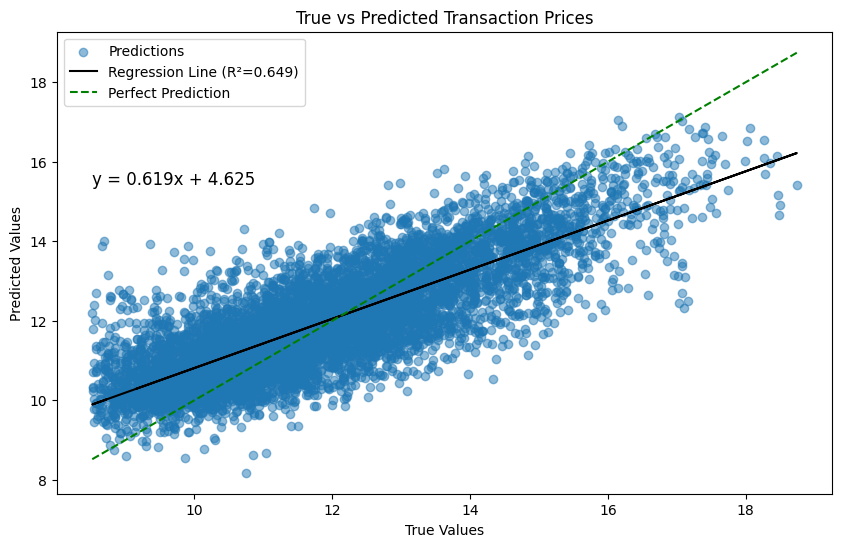

(44650, 375)


In [11]:
fit_visualization(y_test, preds)
print(X_train.shape)